### Imports

In [ ]:
# Standard library imports
import os
import io
import json
import math

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

# RDKit imports
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import AllChem, DataStructs

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from scipy.special import huber

### Data Frame Reading

In [ ]:
df=pd.read_csv('D2_GPCR.csv',sep=',')
df


,Common name,Smiles,Activity Type,p-value (-log)
0,dopamine,NCCc1ccc(O)c(O)c1,IC50,4.00
1,CHEMBL1259071,Cc1ccc(CNCC2(F)CCN(C(=O)c3cc(Br)cs3)CC2)nc1,Ki,4.00
2,CHEMBL407818,Oc1ccc(N2CCN(Cc3cnn4ccccc34)CC2)cc1,Ki,4.06
3,CHEMBL392401,Oc1cccc(C2NCCc3c2[nH]c2ccccc32)c1,Ki,4.06
4,procaterol,CCC(NC(C)C)C(O)c1ccc(O)c2[nH]c(=O)ccc12,Ki,4.07
...,...,...,...,...
10157,CHEMBL5221974,CC(NC(=O)/N=C(\N)NCCCc1nnc(N)s1)c1cccc(F)c1,Kd,10.83
10158,CHEMBL5222491,C[C@@H](NC(=O)/N=C(\N)NCCCc1ncn[nH]1)c1ccccc1,Kd,10.83
10159,lisuride,CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@H...,EC50,11.00
10160,nemonapride,CNc1cc(OC)c(C(=O)NC2CCN(Cc3ccccc3)C2C)cc1Cl,pKi,11.00


In [ ]:
count = df["Activity Type"].value_counts()
smiles = df["Smiles"].count()
count

Activity Type
Ki       8213
pKi      1107
IC50      369
EC50      353
Kd        104
AC50       12
pIC50       4
Name: count, dtype: int64

In [ ]:
unique_smiles_count = df["Smiles"].nunique()
total_count = len(df["Smiles"])
isna=df["Smiles"].isna().sum()

print(f"Number of NaN values:", isna)
print("Unique SMILES:", unique_smiles_count)
print("Total SMILES entries:", total_count)

Number of NaN values: 0
Unique SMILES: 7313
Total SMILES entries: 10162


In [ ]:
# Starting from from the original df
df_ki_all = df[df['Activity Type'] == 'Ki']

print(f"Total 'Ki' entries found in the original DataFrame: {df_ki_all.shape[0]}")

Total 'Ki' entries found in the original DataFrame: 8213


In [ ]:
# Santize
df_to_sanitize = df_ki_all.copy()

# this is the salt remover tool
remover = SaltRemover()

canonical_smiles_list = []

# Loop through every SMILES string
for smiles_string in df_to_sanitize['Smiles']:

    # Try to read the SMILES
    mol = Chem.MolFromSmiles(smiles_string)

    if mol is None:
        canonical_smiles_list.append(None)
    else:
        desalted_mol = remover.StripMol(mol)

        # Creating the standard canonical SMILES
        canonical_smiles = Chem.MolToSmiles(desalted_mol, isomericSmiles=True)
        canonical_smiles_list.append(canonical_smiles)

df_to_sanitize.loc[:, 'Smiles_canonical'] = canonical_smiles_list

invalid_count = df_to_sanitize['Smiles_canonical'].isna().sum()
if invalid_count > 0:
    print(f"Found {invalid_count} invalid SMILES. Removing them.")
    df_to_sanitize = df_to_sanitize.dropna(subset=['Smiles_canonical'])
else:
    print("No invalid SMILES found.")

df_final_clean = df_to_sanitize.drop_duplicates(subset=['Smiles_canonical'], keep='first')

print(f"Final clean rows after deduplication: {df_final_clean.shape[0]}")

No invalid SMILES found.
Final clean rows after deduplication: 6640


In [ ]:
df_final_clean

,Common name,Smiles,Activity Type,p-value (-log),Smiles_canonical
1,CHEMBL1259071,Cc1ccc(CNCC2(F)CCN(C(=O)c3cc(Br)cs3)CC2)nc1,Ki,4.00,Cc1ccc(CNCC2(F)CCN(C(=O)c3cc(Br)cs3)CC2)nc1
2,CHEMBL407818,Oc1ccc(N2CCN(Cc3cnn4ccccc34)CC2)cc1,Ki,4.06,Oc1ccc(N2CCN(Cc3cnn4ccccc34)CC2)cc1
3,CHEMBL392401,Oc1cccc(C2NCCc3c2[nH]c2ccccc32)c1,Ki,4.06,Oc1cccc(C2NCCc3c2[nH]c2ccccc32)c1
4,procaterol,CCC(NC(C)C)C(O)c1ccc(O)c2[nH]c(=O)ccc12,Ki,4.07,CCC(NC(C)C)C(O)c1ccc(O)c2[nH]c(=O)ccc12
5,OLICERIDINE,COc1ccsc1CNCC[C@@]1(c2ccccn2)CCOC2(CCCC2)C1,Ki,4.08,COc1ccsc1CNCC[C@@]1(c2ccccn2)CCOC2(CCCC2)C1
...,...,...,...,...,...
10103,CHEMBL4245263,O=S(=O)(c1cncc2ccccc12)N1CCC[C@H]1CCN1CCC(c2no...,Ki,10.00,O=S(=O)(c1cncc2ccccc12)N1CCC[C@H]1CCN1CCC(c2no...
10117,CHEMBL1851893,O=c1ccc2ccc(OCCCCN3CCN(c4ccccc4OCCF)CC3)cc2[nH]1,Ki,10.15,O=c1ccc2ccc(OCCCCN3CCN(c4ccccc4OCCF)CC3)cc2[nH]1
10120,metopimazine,CS(=O)(=O)c1ccc2c(c1)N(CCCN1CCC(C(N)=O)CC1)c1c...,Ki,10.15,CS(=O)(=O)c1ccc2c(c1)N(CCCN1CCC(C(N)=O)CC1)c1c...
10128,CHEMBL1257382,O=C1NCc2ccc(OCCCCN3CCN(c4cccc5c4CCC5)CC3)cc21,Ki,10.24,O=C1NCc2ccc(OCCCCN3CCN(c4cccc5c4CCC5)CC3)cc21


- The df_final_clean has canonical smiles which basically means that the SMILES column underwent and became single, unique, and standard representation and also salt removal was applied.


- The dataset has been identified by KI first which is the most common activity type and I wanted to do the pki with Ki but actually found out after filtering its number its too low so I had to remove it. Then we made ma copy of the data set and applied the RDkit including *removing salts and canonicalization* as it was mentioned on Teams that we should not do it extensively.

- This should have the data now being both standardized and cleaned.

- Also fyi use the smiles_canonical as this is the new sanitized smiles column.

### RDkit Descriptors XGB

In [ ]:
try:
    # creating a copy to avoid errors
    bridge_df = df_final_clean.copy()

    if 'p-value (-log)' in bridge_df.columns:
        print("p-value (-log) renamed to pKi")
        bridge_df = bridge_df.rename(columns={"p-value (-log)": "pKi"})
    else:
        print("error")

    # splitting data
    # this creates df_train and df_test for me to use
    df_train, df_test = train_test_split(bridge_df, test_size=0.2, random_state=42)

    print("splitting done")
    print(f"training set size (df_train): {len(df_train)}")
    print(f"testing set size (df_test): {len(df_test)}")

except KeyError as e:
    print(f"error")

p-value (-log) renamed to pKi
splitting done
training set size (df_train): 5312
testing set size (df_test): 1328


In [ ]:
# featurization (RDKit Descriptors)

# calculating descriptors for training set
descriptor_names = [name for name, _ in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def calculate_descriptors(smiles_list):
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    descriptors_list = []
    for mol in mols:
        try:
            descriptors = calculator.CalcDescriptors(mol)
            descriptors_list.append(descriptors)
        except:
            descriptors_list.append([np.nan] * len(descriptor_names))
    return np.array(descriptors_list)

X_train_raw = calculate_descriptors(df_train['Smiles_canonical'])

# calculating descriptors for testing set
X_test_raw = calculate_descriptors(df_test['Smiles_canonical'])
y_train = df_train['pKi'].values
y_test = df_test['pKi'].values

print("\nfeaturization complete")


featurization complete


In [ ]:
# pre-processing
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_imputed)
X_test_processed = scaler.transform(X_test_imputed)
print("data successfully imputed and scaled")

data successfully imputed and scaled


In [ ]:
# model training: XGBoost

model_xgb = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, early_stopping_rounds=50, random_state=42)
model_xgb.fit(X_train_processed, y_train, eval_set=[(X_test_processed, y_test)], verbose=False)
print("model training complete")

model training complete


RDKit + XGBoost Performance
------------------------------
R-squared (R²):                  0.658
Root Mean Square Error (RMSE):    0.608
Mean Absolute Error (MAE):       0.454
Median Absolute Error (MedAE):    0.347
Huber Loss (delta=1.0):          0.173


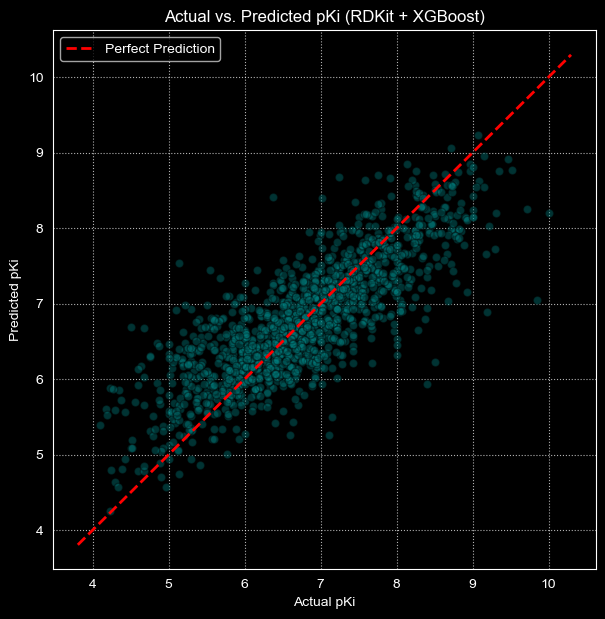

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

# 1. Vectorized Huber Loss (Fixes the "truth value of an array" error)
def calculate_huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * np.square(error)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

# 2. Generate Predictions
y_pred_xgb = model_xgb.predict(X_test_processed)

# 3. Calculate Metrics
r2 = r2_score(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
medae = median_absolute_error(y_test, y_pred_xgb)
h_loss = calculate_huber_loss(y_test, y_pred_xgb, delta=1.0)

# 4. Print Results
print("RDKit + XGBoost Performance")
print("-" * 30)
print(f"R-squared (R²):                  {r2:.3f}")
print(f"Root Mean Square Error (RMSE):    {rmse:.3f}")
print(f"Mean Absolute Error (MAE):       {mae:.3f}")
print(f"Median Absolute Error (MedAE):    {medae:.3f}")
print(f"Huber Loss (delta=1.0):          {h_loss:.3f}")

# 5. Visualization
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_xgb, alpha=0.4, color='teal', edgecolors='k')

# Drawing the identity line
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'r--', lw=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted pKi (RDKit + XGBoost)')
plt.xlabel('Actual pKi')
plt.ylabel('Predicted pKi')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

In [ ]:
model_filename = 'rdkit_xgboost_model.json'
model_xgb.save_model(model_filename)
print(f"Model saved to {model_filename}")

results_filename = 'rdkit_xgboost_results.npz'
np.savez(results_filename, y_test=y_test, y_pred=y_pred_xgb, model_name='RDKit+XGBoost')
print(f"Results saved to {results_filename}")

Model saved to rdkit_xgboost_model.json
Results saved to rdkit_xgboost_results.npz


In [ ]:
from pathlib import Path

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Artifacts will be saved to: {ARTIFACTS_DIR.as_posix()}")

Artifacts will be saved to: artifacts


### RDkit Descriptors MLP

In [ ]:
# --- 0) Preconditions ---
# We expect: df_final_clean and a column "Smiles_canonical"
assert 'Smiles_canonical' in df_final_clean.columns, "Expected 'Smiles_canonical' from Student 1."

# Rename the relevant column to a recognized target name
if 'p-value (-log)' in df_final_clean.columns:
    df_final_clean = df_final_clean.rename(columns={'p-value (-log)': 'pKi'})

# Detect a numeric target column (Ki-based). Common names: 'Activity Value', 'Ki', 'pKi', etc.
import pandas as pd
target_candidates = [c for c in df_final_clean.columns if c.lower() in ('activity value','activity_value','ki','pki','value')]
if not target_candidates:
    raise ValueError("Couldn't find a numeric activity/target column. Please ensure a column named 'Ki', 'pKi', 'Activity Value', or 'value' exists and is numeric.")
target_col = target_candidates[0]
print("Using target column:", target_col)

# Ensure target is numeric
df_final_clean[target_col] = pd.to_numeric(df_final_clean[target_col], errors='coerce')
df_final_clean = df_final_clean.dropna(subset=[target_col]).reset_index(drop=True)
print("Rows after ensuring numeric target:", df_final_clean.shape[0])

Using target column: pKi
Rows after ensuring numeric target: 6640


This step ensures our dataset has a clean, numeric activity column for model training.
It first renames 'p-value (-log)' to 'pKi' if present, then automatically detects which column holds the activity values (like Ki, pKi, or Activity Value).
Finally, it converts that column to numeric, drops any missing entries, and reports how many valid rows remain (here 6,640 molecules with numeric pKi values).

In [ ]:
def _sanitize_mol_from_smiles(smi: str):
    """Parse, sanitize, light standardization (desalt/neutralize); return RDKit Mol or None."""
    if not isinstance(smi, str) or not smi.strip():
        return None
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    try:
        Chem.SanitizeMol(mol)
    except Exception:
        return None
    try:
        clean = rdMolStandardize.Cleanup(mol)
        uncharged = rdMolStandardize.Uncharge(clean)
        parent = rdMolStandardize.FragmentParent(uncharged)
        return parent
    except Exception:
        return mol  # fallback

def descriptor_names_excluding(exclude=('Ipc',)):
    names = [d[0] for d in Descriptors.descList]
    return [n for n in names if n not in set(exclude)]

def compute_descriptor_row(mol, names):
    row = []
    for n in names:
        try:
            v = getattr(Descriptors, n)(mol)
        except Exception:
            v = np.nan
        row.append(v)
    return row

desc_names = descriptor_names_excluding()
print(f"Total RDKit descriptors (excl. Ipc): {len(desc_names)}")

X_rows = []
valid_mask = []
for smi in df_final_clean['Smiles_canonical']:
    mol = _sanitize_mol_from_smiles(smi)
    if mol is None:
        X_rows.append([np.nan]*len(desc_names))
        valid_mask.append(False)
    else:
        X_rows.append(compute_descriptor_row(mol, desc_names))
        valid_mask.append(True)

import pandas as pd
X_raw = pd.DataFrame(X_rows, columns=desc_names)

# Handle NaN and inf values
X_raw = X_raw.replace([np.inf, -np.inf], np.nan)

y_raw = df_final_clean[target_col].copy()

# Drop rows with NaN values from both X_raw and y_raw
original_rows = X_raw.shape[0]
combined = pd.concat([X_raw, y_raw], axis=1)
combined = combined.dropna()
X_raw = combined.drop(columns=[target_col])
y_raw = combined[target_col]

print(f"Dropped {original_rows - X_raw.shape[0]} rows containing NaN values.")
print("Final descriptor matrix shape:", X_raw.shape)
print("Final target vector shape:", y_raw.shape)

# Save descriptor names to a JSON file for later use in inference
descriptor_list_path = ARTIFACTS_DIR / "descriptor_names.json"
with open(descriptor_list_path, "w") as f:
    json.dump(list(X_raw.columns), f)
print("Saved descriptor names to:", descriptor_list_path.as_posix())

Total RDKit descriptors (excl. Ipc): 216


[19:28:15] Initializing MetalDisconnector
[19:28:15] Running MetalDisconnector
[19:28:15] Initializing Normalizer
[19:28:15] Running Normalizer
[19:28:15] Initializing MetalDisconnector
[19:28:15] Running MetalDisconnector
[19:28:15] Initializing Normalizer
[19:28:15] Running Normalizer
[19:28:15] Initializing MetalDisconnector
[19:28:15] Running MetalDisconnector
[19:28:15] Initializing Normalizer
[19:28:15] Running Normalizer
[19:28:15] Initializing MetalDisconnector
[19:28:15] Running MetalDisconnector
[19:28:15] Initializing Normalizer
[19:28:15] Running Normalizer
[19:28:15] Initializing MetalDisconnector
[19:28:15] Running MetalDisconnector
[19:28:15] Initializing Normalizer
[19:28:15] Running Normalizer
[19:28:15] Initializing MetalDisconnector
[19:28:15] Running MetalDisconnector
[19:28:15] Initializing Normalizer
[19:28:15] Running Normalizer
[19:28:15] Initializing MetalDisconnector
[19:28:15] Running MetalDisconnector
[19:28:15] Initializing Normalizer
[19:28:15] Running Nor

Dropped 4 rows containing NaN values.
Final descriptor matrix shape: (6636, 216)
Final target vector shape: (6636,)
Saved descriptor names to: artifacts/descriptor_names.json


[19:29:06] Initializing MetalDisconnector
[19:29:06] Running MetalDisconnector
[19:29:06] Initializing Normalizer
[19:29:06] Running Normalizer
[19:29:06] Initializing MetalDisconnector
[19:29:06] Running MetalDisconnector
[19:29:06] Initializing Normalizer
[19:29:06] Running Normalizer


This part converts each molecule (using its Smiles_canonical) into 216 numerical RDKit descriptors, while skipping the unstable Ipc feature. It automatically sanitizes and neutralizes every molecule, removes any rows with missing descriptor values (only 4 dropped), and matches the cleaned target values. The final dataset now contains 6,636 molecules × 216 descriptors, and the descriptor names are saved to artifacts/descriptor_names.json for reproducibility.

In [ ]:
# --- 3) Train / test split (80/20, same seed as team) ---
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.20, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape

((5308, 216), (1328, 216))

The dataset is split into 80% training and 20% testing using a fixed random seed (42) to ensure reproducibility and match the team’s setup.
This gives 5,308 molecules for training and 1,328 molecules for testing, each represented by 216 RDKit descriptors.
The split ensures the model is trained on most data while keeping unseen examples to fairly evaluate its performance.

In [ ]:
# --- 4) Pipeline: StandardScaler -> MLPRegressor ---
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=RANDOM_STATE,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.10
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", mlp),
])
pipe


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(128, 64),
                              max_iter=500, n_iter_no_change=20,
                              random_state=42))])

This builds a machine learning pipeline combining two steps — feature scaling and model training.
The StandardScaler normalizes all 216 descriptors so the MLP can learn efficiently, while the MLPRegressor (with two hidden layers of 128 and 64 neurons) models the relationship between descriptors and activity.
Using a pipeline keeps preprocessing and training linked together, ensuring consistent scaling during both training and future predictions.

In [ ]:
# --- 5) Train & evaluate ---
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

r2   = r2_score(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
medae=median_absolute_error(y_test, y_pred)
huber_loss=calculate_huber_loss(y_test, y_pred,delta=1)

print({"R2": r2, "RMSE": rmse, "MAE": mae, "Medae": medae, "Huber_loss": huber_loss})

# Export metrics for Student 6 consolidation
metrics_df = pd.DataFrame([{
    "model": "MLP",
    "representation": "RDKit_Descriptors",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae,
    "Medae": medae,
    "Huber_loss": huber_loss
}])
metrics_path = ARTIFACTS_DIR / "metrics_rdkit_mlp.csv"
metrics_df.to_csv(metrics_path, index=False)
print("Saved metrics ->", metrics_path.as_posix())


{'R2': 0.46489971648954875, 'RMSE': 0.7499463641644931, 'MAE': 0.5414463423731286, 'Medae': 0.4066296409618104, 'Huber_loss': 0.2332975173807001}
Saved metrics -> artifacts/metrics_rdkit_mlp.csv


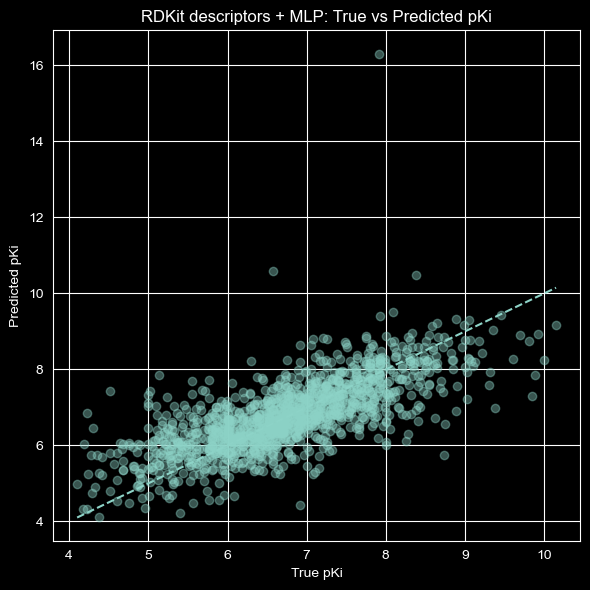

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True pKi")
plt.ylabel("Predicted pKi")
plt.title("RDKit descriptors + MLP: True vs Predicted pKi")
plt.grid(True)
plt.tight_layout()
plt.show()


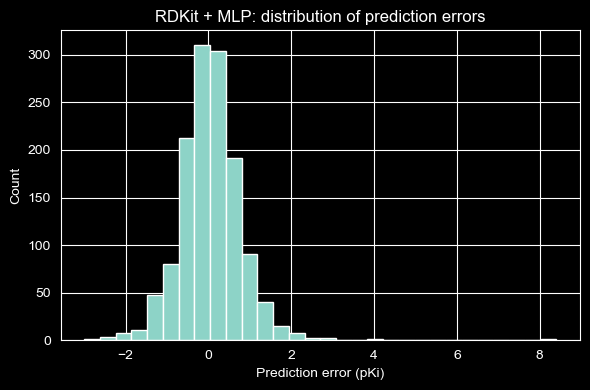

In [ ]:
errors = y_pred - y_test

plt.figure(figsize=(6, 4))
plt.hist(errors, bins=30)
plt.xlabel("Prediction error (pKi)")
plt.ylabel("Count")
plt.title("RDKit + MLP: distribution of prediction errors")
plt.tight_layout()
plt.show()


### Morgan Fingerprints + XGBoost

In [ ]:
# Function to generate a Morgan fingerprint for a given SMILES string
def morgan_fp(smiles, radius=2, nBits=2048):
    """
    Converts a SMILES string into a Morgan fingerprint.
    The output is a fixed-length vector of 0s and 1s that captures
    the structural information of the molecule.
    """
    mol = Chem.MolFromSmiles(smiles)

    # Create an empty vector and convert the fingerprint into a numpy array
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    fp_array = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, fp_array)

    return fp_array



In this step, We created a function that converts each molecule (SMILES string) into a Morgan fingerprint.
A fingerprint is basically a long vector of 0s and 1s that describes the chemical structure in a numerical form.
Machine learning models cannot read SMILES directly, so this step prepares the molecules for ML training.

In [ ]:
# Each SMILES string is converted into a numerical vector using the morgan_fp function.
X_fp = np.stack(df_final_clean["Smiles_canonical"].apply(morgan_fp))

# Extract the activity values and convert them into a numeric array for model training.
y = df_final_clean["pKi"].astype(float).to_numpy()

[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerator
[19:29:09] DEPRECATION WARNING: please use MorganGenerat

Here the fingerprint function is applied to all cleaned SMILES to generate X_fp, which contains the numerical features for every molecule.
Also extracted the activity values into y.
So this cell produces the final dataset that will be used for training the ML models.

In [ ]:
# Create an array of index positions for the full dataset
idx = np.arange(len(df_final_clean))

# Split the indices into training (80%) and testing (20%) sets
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

# Use the split indices to separate the fingerprints and target values
Xtr_fp, Xte_fp = X_fp[train_idx], X_fp[test_idx]
ytr, yte = y[train_idx], y[test_idx]



In this cell,the whole dataset slits into training (80%) and testing (20%) sets.
The training set is used to teach the model, while the test set helps us check how well the model performs on molecules it has never seen before.

Morgan + XGBoost → RMSE: 0.6173826721827481  | R2: 0.6472646238870756 mae 0.4685094892404166 medae 0.3558364105224614 huber_loss 0.1785329805709629


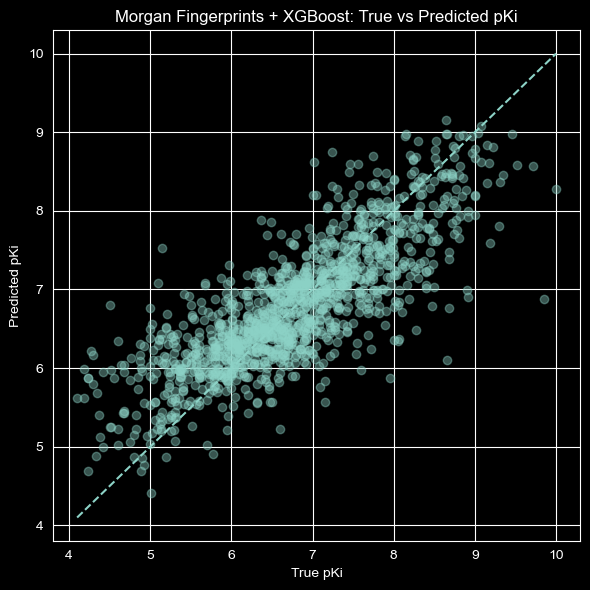

In [ ]:
# Initialize and train the XGBoost model
xgb_fp = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_fp.fit(Xtr_fp, ytr)

# Generate predictions for the test set using the trained XGBoost model
pred = xgb_fp.predict(Xte_fp)

# RMSE shows the average prediction error (lower is better)
rmse = np.sqrt(mean_squared_error(yte, pred))
mae = mean_absolute_error(yte, pred)
medae = median_absolute_error(yte, pred)
huber_loss=calculate_huber_loss(yte, pred,delta=1)

# R2 indicates how much variance in the data the model can explain (higher is better)
r2 = r2_score(yte, pred)

print("Morgan + XGBoost → RMSE:", rmse, " | R2:", r2,"mae",mae,"medae",medae,"huber_loss",huber_loss)

plt.figure(figsize=(6, 6))
plt.scatter(yte, pred, alpha=0.4)
plt.plot([yte.min(), yte.max()],
         [yte.min(), yte.max()],
         linestyle="--")
plt.xlabel("True pKi")
plt.ylabel("Predicted pKi")
plt.title("Morgan Fingerprints + XGBoost: True vs Predicted pKi")
plt.grid(True)
plt.tight_layout()
plt.show()

this step trains an XGBoost regression model using the Morgan fingerprints.
After training, the activities of the test molecules and calculated RMSE and R² are predicted.
Lower RMSE and higher R² mean a better model.
These values show how well XGBoost learns the relationship between structure and activity.

### Morgan Fingerprints + MLP

In [ ]:
# Build a neural network model (MLP) to learn from the Morgan fingerprints
mlp_fp = MLPRegressor(
    hidden_layer_sizes=(256, 128),   # two hidden layers with 256 and 128 neurons
    activation="relu",               # ReLU helps the model learn complex patterns
    max_iter=800,                    # number of training iterations
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42)

# Train the MLP model on the training fingerprints
mlp_fp.fit(Xtr_fp, ytr)


pred_mlp = mlp_fp.predict(Xte_fp)

# Compute RMSE (how large the average error is)
rmse_mlp = np.sqrt(mean_squared_error(yte, pred_mlp))
mae=mean_absolute_error(yte, pred_mlp)
medae=median_absolute_error(yte, pred_mlp)
huber_loss=calculate_huber_loss(yte, pred_mlp,delta=1)

# Compute R² score (how much of the data variance the model explains)
r2_mlp = r2_score(yte, pred_mlp)

print("Morgan + MLP → RMSE:", rmse_mlp, " | R2:", r2_mlp,"mae",mae,"medae",medae,"huber_loss",huber_loss)



Morgan + MLP → RMSE: 0.662786181749563  | R2: 0.5934752082770708 mae 0.49804204193488916 medae 0.37898535090387897 huber_loss 0.19972734079138424


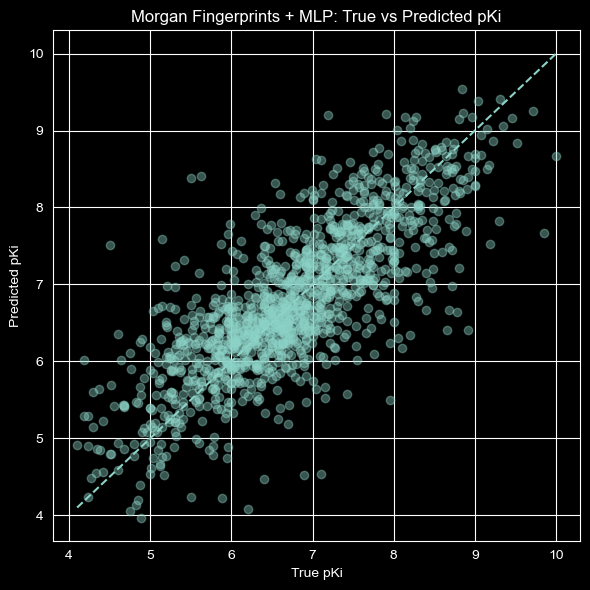

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(yte, pred_mlp, alpha=0.4)
plt.plot(
    [yte.min(), yte.max()],
    [yte.min(), yte.max()],
    linestyle="--"
)
plt.xlabel("True pKi")
plt.ylabel("Predicted pKi")
plt.title("Morgan Fingerprints + MLP: True vs Predicted pKi")
plt.grid(True)
plt.tight_layout()
plt.show()


The plot shows a strong linear trend between true and predicted pKi.
The MLP captures the overall structure–activity trend well, especially in the mid-range (6–8 pKi).
Some scatter appears for extreme pKi values, which is typical of QSAR models under activity imbalance.

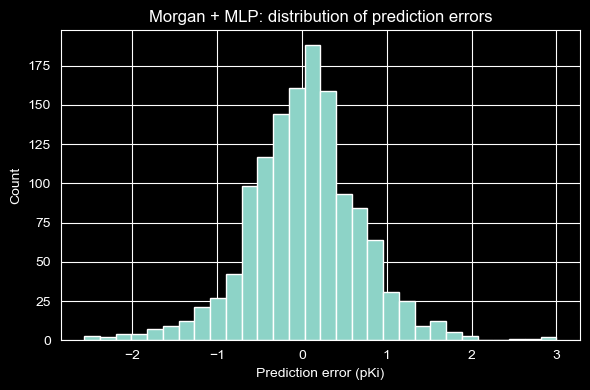

In [ ]:
errors_mlp = pred_mlp - yte

plt.figure(figsize=(6, 4))
plt.hist(errors_mlp, bins=30)
plt.xlabel("Prediction error (pKi)")
plt.ylabel("Count")
plt.title("Morgan + MLP: distribution of prediction errors")
plt.tight_layout()
plt.show()


The error distribution is centered around zero, meaning the model is not systematically over- or under-predicting.
Most predictions fall within ±1 pKi, indicating reasonable accuracy and consistent behavior.
The overall error shape is approximately Gaussian, showing stable learning.

In this cell, a neural network (MLP) on the same fingerprint data is trained.
The model tries to learn deeper non-linear chemical patterns.
Again, RMSE and R² were calculated on the test set to measure accuracy.
These results allow us to compare the performance of MLP against XGBoost.

### Analysis

In [ ]:
results = pd.DataFrame({
    "Model": ["Morgan+XGB", "Morgan+MLP"],
    "RMSE":  [0.6173826721827481, rmse_mlp],
    "R2":    [0.6335733949229442, r2_mlp],
}).sort_values("RMSE")

results


,Model,RMSE,R2
0,Morgan+XGB,0.617383,0.633573
1,Morgan+MLP,0.662786,0.593475


Finally, a small comparison table to summarize the performance of both models is created.
By checking RMSE (lower is better) and R² (higher is better), we can clearly see which model performs best.
This makes it easy to report the final results and show the difference between XGBoost and MLP.

In [ ]:
results = pd.DataFrame({
    "Model": ["RDKit + XGBoost", "RDKit + MLP", "Morgan + XGBoost", "Morgan + MLP"],
    "RMSE":  [0.608, 0.758223, 0.617383, 0.662786],
    "R2":    [0.658, 0.453023, 0.647265, 0.593475],
    "MAE" : [0.454,0.5414,0.4658,0.4980],
    "MedAE": [0.347,0.4066,0.3558,0.3789],
    "Huber Loss": [0.147,0.2332,0.1785,0.1997]
})
results

,Model,RMSE,R2,MAE,MedAE,Huber Loss
0,RDKit + XGBoost,0.608000,0.658000,0.4540,0.3470,0.1470
1,RDKit + MLP,0.758223,0.453023,0.5414,0.4066,0.2332
2,Morgan + XGBoost,0.617383,0.647265,0.4658,0.3558,0.1785
3,Morgan + MLP,0.662786,0.593475,0.4980,0.3789,0.1997


In [ ]:
best_model = results.loc[results['RMSE'].idxmin()]
print(" Best Model Based on Lowest RMSE:")
print(best_model)


 Best Model Based on Lowest RMSE:
Model         RDKit + XGBoost
RMSE                    0.608
R2                      0.658
MAE                     0.454
MedAE                   0.347
Huber Loss              0.147
Name: 0, dtype: object


In this step, best-performing model by comparing the RMSE values of all models in the results table is selected. The model with the lowest RMSE is considered the most accurate because it makes the smallest prediction error. This cell simply locates that model and prints its details, so I can clearly see which approach worked best.

As we can see here in this graph .

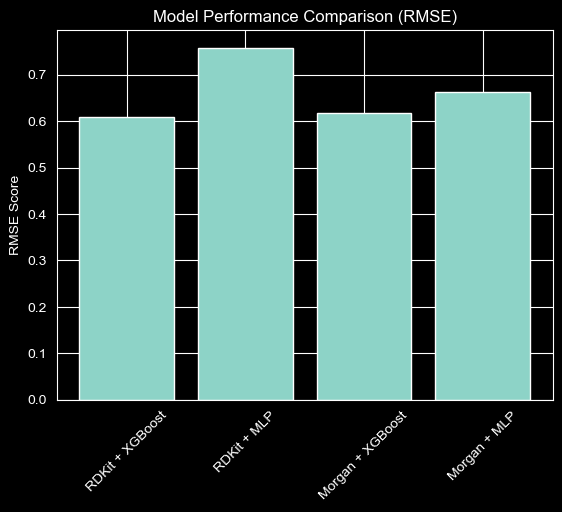

In [ ]:
plt.bar(results["Model"], results["RMSE"])
plt.title("Model Performance Comparison (RMSE)")
plt.ylabel("RMSE Score")
plt.xticks(rotation=45)
plt.show()

### Challenge Data Set

Found 2 invalid SMILES in challenge dataset. Removing them.
Challenge set size: 467
Challenge RMSE: 1.0561
Challenge R²  : 0.0884
Challenge MAE  : 0.8971
Challenge MedAE:0.8903
Challenge Huber Loss:0.4895


[19:29:21] SMILES Parse Error: syntax error while parsing: -
[19:29:21] SMILES Parse Error: check for mistakes around position 1:
[19:29:21] -
[19:29:21] ^
[19:29:21] SMILES Parse Error: Failed parsing SMILES '-' for input: '-'
[19:29:21] SMILES Parse Error: syntax error while parsing: -
[19:29:21] SMILES Parse Error: check for mistakes around position 1:
[19:29:21] -
[19:29:21] ^
[19:29:21] SMILES Parse Error: Failed parsing SMILES '-' for input: '-'
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DEPRECATION WARNING: please use MorganGenerator
[19:29:21] DE

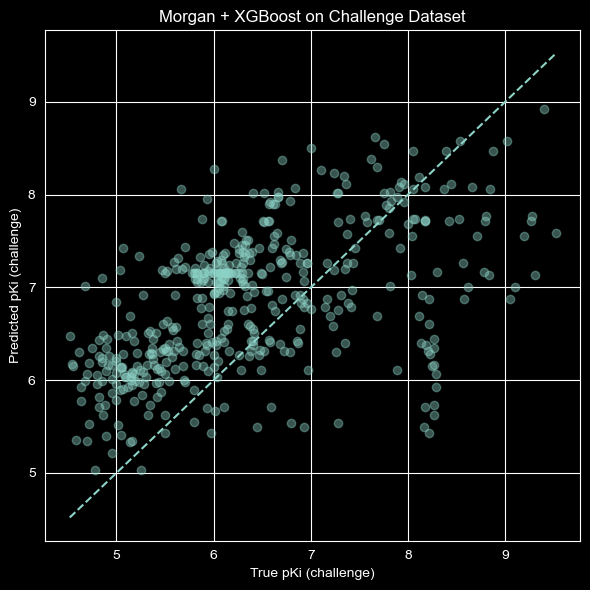

In [ ]:
# --- path to the challenge dataset ---
challenge_path = "challenge_data.csv"

# 1) Load challenge dataset
challenge = pd.read_csv(challenge_path)

# 2) Standardize activity column name → pKi
if "p-value (-log)" in challenge.columns and "pKi" not in challenge.columns:
    challenge = challenge.rename(columns={"p-value (-log)": "pKi"})

# Add the canonicalization and salt removal step for the challenge dataset
remover = SaltRemover()
canonical_smiles_list_challenge = []

# Loop through every SMILES string in the challenge dataset's 'Smiles' column
for smiles_string in challenge['Smiles']:
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        canonical_smiles_list_challenge.append(None)
    else:
        desalted_mol = remover.StripMol(mol)
        canonical_smiles = Chem.MolToSmiles(desalted_mol, isomericSmiles=True)
        canonical_smiles_list_challenge.append(canonical_smiles)

challenge.loc[:, 'Smiles_canonical'] = canonical_smiles_list_challenge

invalid_count_challenge = challenge['Smiles_canonical'].isna().sum()
if invalid_count_challenge > 0:
    print(f"Found {invalid_count_challenge} invalid SMILES in challenge dataset. Removing them.")
    challenge = challenge.dropna(subset=['Smiles_canonical'])
else:
    print("No invalid SMILES found in challenge dataset.")


if "pKi" not in challenge.columns:
    raise ValueError("Could not find a 'pKi' column in the challenge dataset.")

if "Smiles_canonical" not in challenge.columns:
    raise ValueError("Could not find a 'Smiles_canonical' column in the challenge dataset.")

# 3) Clean target + SMILES
challenge["pKi"] = pd.to_numeric(challenge["pKi"], errors="coerce")
challenge = challenge.dropna(subset=["pKi", "Smiles_canonical"]).reset_index(drop=True)

y_challenge = challenge["pKi"].to_numpy()
smiles_challenge = challenge["Smiles_canonical"].astype(str).to_numpy()

print("Challenge set size:", len(y_challenge))

# 4) Compute Morgan fingerprints with your existing morgan_fp()
X_challenge_fp = np.stack([morgan_fp(smi) for smi in smiles_challenge])

# 5) Predict with your already-trained XGBoost model
y_pred_challenge = xgb_fp.predict(X_challenge_fp)

# 6) Evaluate
rmse_ch = np.sqrt(mean_squared_error(y_challenge, y_pred_challenge))
r2_ch   = r2_score(y_challenge, y_pred_challenge)
medae_ch=median_absolute_error(y_challenge, y_pred_challenge)
mae=mean_absolute_error(y_challenge, y_pred_challenge)
huber_loss_ch=calculate_huber_loss(y_challenge, y_pred_challenge,delta=1)

print(f"Challenge RMSE: {rmse_ch:.4f}")
print(f"Challenge R²  : {r2_ch:.4f}")
print(f"Challenge MAE  : {mae:.4f}")
print(f"Challenge MedAE:{medae_ch:.4f}")
print(f"Challenge Huber Loss:{huber_loss_ch:.4f}")

# 7) Visualise: True vs Predicted pKi on challenge set
plt.figure(figsize=(6, 6))
plt.scatter(y_challenge, y_pred_challenge, alpha=0.4)
plt.plot(
    [y_challenge.min(), y_challenge.max()],
    [y_challenge.min(), y_challenge.max()],
    linestyle="--"
)
plt.xlabel("True pKi (challenge)")
plt.ylabel("Predicted pKi (challenge)")
plt.title("Morgan + XGBoost on Challenge Dataset")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
results2 = pd.DataFrame({
    "Model": ["RDKit + XGBoost", "RDKit + MLP", "Morgan + XGBoost", "Morgan + MLP","Challenge Set"],
    "RMSE":  [0.608, 0.758223, 0.617383, 0.662786,1.056],
    "R2":    [0.658, 0.453023, 0.647265, 0.593475,0.0884],
    "MAE" : [0.454,0.5414,0.4658,0.4980,0.8971],
    "MedAE": [0.347,0.4066,0.3558,0.3789,0.8903],
    "Huber Loss": [0.147,0.2332,0.1785,0.1997,0.4895]
})


# 3. Display sorted by ranking ability (Spearman)
results2

,Model,RMSE,R2,MAE,MedAE,Huber Loss
0,RDKit + XGBoost,0.608000,0.658000,0.4540,0.3470,0.1470
1,RDKit + MLP,0.758223,0.453023,0.5414,0.4066,0.2332
2,Morgan + XGBoost,0.617383,0.647265,0.4658,0.3558,0.1785
3,Morgan + MLP,0.662786,0.593475,0.4980,0.3789,0.1997
4,Challenge Set,1.056000,0.088400,0.8971,0.8903,0.4895


Model Performance on Challenge Data: The Morgan + XGBoost model was applied to the challenge dataset. The results are:

Challenge RMSE: 1.0561
Challenge R²: 0.0884
This R² value is significantly lower than the R² achieved on the original test set (0.647). This indicates that while the model performed reasonably well on the data it was trained and tested on, it did not generalize effectively to the new challenge_data.csv dataset. This could be due to differences in the chemical space or activity ranges between your training data and the challenge data, or simply that the model was overfitted to the training data. The plot further visualizes this poor generalization, showing a weak correlation between true and predicted pKi values on the challenge set.


## Task02: The Truth About "Binding Affinity" in Public Datasets and How to Fix It

### 1. What Binding Affinity Really Is (Thermodynamic Definition)

Binding affinity describes the strength of the non-covalent interaction between a ligand (L) and its target protein (P):

$$
\mathrm{P + L \rightleftharpoons PL}
$$

True thermodynamic binding affinity is quantified by the **equilibrium dissociation constant** $ K_d $:

$$
K_d = \frac{[\mathrm{P}][\mathrm{L}]}{[\mathrm{PL}]} = \frac{k_{\text{off}}}{k_{\text{on}}}
$$

or by the standard Gibbs free energy of binding:

$$
\Delta G^\circ = -RT \ln K_a = RT \ln K_d
$$

Lower $ K_d $ → more negative $ \Delta G^\circ $ → higher affinity

$ \Delta G^\circ = \Delta H^\circ - T\Delta S^\circ $
→ Medicinal chemists optimize both enthalpy (H-bonds, van der Waals) and entropy (hydrophobic effect, water release).

Gold-standard techniques that directly measure true thermodynamic $ K_d $/$ K_i $:
- Isothermal Titration Calorimetry (ITC) → full thermodynamic profile in one experiment
- Surface Plasmon Resonance (SPR) → real-time kinetics ($ k_{\text{on}}, k_{\text{off}} $)

### 2. What Most Public Datasets Actually Contain

| Label you see in ChEMBL / PubChem | What it usually really is              | Assay-dependent? | Thermodynamic constant? |
|-----------------------------------|----------------------------------------|------------------|--------------------------|
| “pKi” or “Ki”                     | Very often uncorrected or partially corrected **IC₅₀** | Yes             | No              |
| “pIC₅₀”                           | Always **IC₅₀**                                 | Strongly        | No              |
| True $ K_d $ or correctly converted $ K_i $ | Rare (only ~10–20 % of entries)               | No              | Yes             |

**IC₅₀** = concentration giving 50 % inhibition in a specific assay
→ Depends heavily on:
- Substrate concentration
- Radioligand / probe concentration ([L*])
- Incubation time
- Detection method
- Temperature, pH, buffer

The **Cheng–Prusoff equation** can convert IC₅₀ → $ K_i $ **only if** [L*] and $ K_d $ of the probe are known:

$$
K_i = \frac{\text{IC}_{50}}{1 + \frac{[\text{L}^*]}{K_d^{\text{probe}}}}
$$

In >90 % of public database entries, this metadata is **missing** → conversion impossible → impossible → people just label IC₅₀ as “Ki”.

### 3. Major Sources of Noise and How Big the Problem Actually Is

| Noise Source                              | Typical Magnitude                  | Reference                              |
|-------------------------------------------|------------------------------------|----------------------------------------|
| Mixing uncorrected IC₅₀ and real Ki       | ≥0.6–1.0 log units                 | Kalliokoski et al., PLoS ONE 2013      |
| Combining data from different labs/assays | 0.5–1.5 log units                  | Landrum & Riniker, JCIM 2024           |
| Unit errors (nM vs µM) or transcription errors| Up to several log units            | Common in ChEMBL                       |
| Inherent experimental reproducibility     | ~0.3 log units (best case)         | Typical ∆pIC₅₀ < 0.3 = same assay      |



### 4. Consequences for Modeling
* **Hidden Noise:** Combining data from different sources introduces significant noise, which may be hidden until tested against clean benchmarks.
* **Generalization Failure:** Models trained on noisy data may overfit; performance often drops on strictly filtered "challenge" datasets or scaffold-aware splits that differ structurally from the training set.
* **Biased Benchmarks:** High performance on random splits often reflects the memorization of training patterns rather than the learning of true structure-activity relationships.

### 5. Methodological Solutions

**Ranking over Regression:** Since the noise in labels is often irreducible, using an **intra-assay ranking loss** is a better approach than standard regression.
* **Multitask Learning:** Treating $IC_{50}$, $K_i$, and $K_d$ as separate tasks allows the model to learn shared patterns without collapsing incompatible labels.
* **Data Consistency Checks:** Assays should only be merged if shared reference compounds differ by less than the experimental error (typically $\Delta pIC_{50} < 0.3$).
* **Assay-Aware Modeling:** Including metadata as for example ,protein variants and assay type, helps models adjust for experimental variance and stabilizes predictions.




### References

- Kalliokoski et al. (2013). Comparability of Mixed IC₅₀ Data – A Statistical Analysis. *PLoS ONE* 8(4): e61007
- Landrum & Riniker (2024). Combining IC₅₀ or Ki Values from Different Sources Is a Source of Significant Noise. *JCIM* 64(5):1560–1567
- Hulme & Trevethick (2010). Ligand binding assays at equilibrium. *Br J Pharmacol* 161(6):1219–1237
- Jarmoskaite et al. (2020). How to measure and evaluate binding affinities. *eLife* 9:e57264


## Task 03: Introduction to Representations


Before training the model we need to understand the chemical meaning and limitations of the input features extracted from the molecular structures (SMILES).


**1. What do these representations describe?**

We used two primary types of 2D representations:

**Morgan Fingerprints (ECFP):**

These encode the local topological environment of each atom. They capture the presence of specific functional groups (e.g., aromatic rings, H-bond donors) by hashing circular substructures into a bit vector, independent of molecular orientation.

**RDKit Physicochemical Descriptors:**

These quantify global molecular properties. Key descriptors include LogP (lipophilicity), TPSA (polar surface area) and MolWt (size). They act as computational proxies for the thermodynamic forces driving binding such as hydrophobic effects and desolvation penalties.


**Graph-Theoretic Indices:**

Descriptors like BertzCT and BalabanJ measure topological complexity and branching. Also, provide a coarse 2D approximation of molecular shape.


**2. Relevance to Binding Affinity**


We assume these representations are highly relevant but insufficient:

**Relevance:**

The hydrophobic effect is a dominant driver of binding affinity in GPCRs (like DRD2). Therefore, descriptors like LogP and HeavyAtomCount (which correlate with buried surface area) are expected to be strong predictors. Morgan fingerprints effectively capture specific anchors (like nitrogen heterocycles) required for key interactions (e.g., Asp114 salt bridge).

**Limitation (Redundancy):**

Our analysis reveals significant collinearity among size dependent features (e.g., MolWt vs. HeavyAtomCount). Without feature selection, this redundancy can destabilize linear models and inflate feature importance.

**3. Missing Features & Future Directions**

The current representations are limited by their 2D nature. Binding is a 3D lock and key event driven by complementary shapes and electrostatic fields.

**Suggested Features:**

To improve model generalizability, we recommend incorporating:

**3D Conformer Ensembles:** To capture spatial volume and shape constraints.

**Pharmacophore Fingerprints:** To explicitly model the spatial arrangement of H-bond donors/acceptors.

**Interaction Fingerprints (PLEC):** If protein structure is available, encoding the specific protein-ligand contacts would bridge the gap between ligand only and structure based design.



## Task04: Metrics and Model Behavior — Beyond RMSE

**Error analysis and Insights**

Our error analysis demonstrates that "Not All Errors Are Equal."
- The model performs well on average molecules but systematically fails on high-affinity binders (the most important drugs).
- The large RMSE is driven by specific outliers outside the applicability domain.
- The model is better at Ranking (Spearman $\rho$) than Regressing (RMSE).

**Model Improvement**

- **Objective Change:** Switch from Regression to **Learning-to-Rank (Pairwise Loss)** to mitigate label noise.
- **Validation Change:** Implement Scaffold Split to realistically simulate the Challenge Se scenario.



